## AB-тест
Команда ML сделала некоторые новые алгоритмы рекомендации новостей в ленте. Ожидается, что новые алгоритмы сделают пользователей счастливее (удлиннится LTV, увеличится денежная конверсия и т.д.)
Команда ML сказала, что чтобы посты стали интереснее было сделано 2 алгоритма:
1. Показывает пользователям посты, похожие на понравившиеся
2. Показывает пользователям посты, которые понравились похожим пользователям

**Придумать показтель, увеличение которого будет говорить, что посты действительно стали интереснее**
- Показателем выбрал **CTR из просмотров в лайки**, потому что есть явное действие, показывающее заинтересованность **(Лайк)**

**Периоды проведения:**
- АА-теста - с 2021-11-13 по 2021-11-15
    + *В моём наборе нет данных за этот период, поэтому проведу АА-тест с 2021-11-16 по 2021-11-18 между двумя контрольными группами*
- АБ-теста - с 2021-11-16 по 2021-11-18
    + *Параллельно идут два теста:*
        1. *exp_group = 1 - Все по-старому. exp_group = 2 - Рекомендации постов, похожих на лайкнутые*
        2. *exp_group = 0 – Все по-старому. exp_group = 3 - Рекомендации постов, которые лайкали похожие люди*



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import hashlib
from scipy import stats
%matplotlib inline

In [2]:
con = sqlite3.connect('db')
def query(sql):
    return pd.read_sql(sql, con)

Создал переменную для подключения к БД и функцию для запросов

### Подготовка данных
Исходные данные имели формат CSV, для изменения формат даты и создания базы данных были проделаны следующие манипуляции
```python
df = pd.read_csv('feed_actions.csv', sep=';')
df['time'] = pd.to_datetime(df['time'],format='%Y-%m-%d %H:%M:%S')
df.to_sql('feed_actions', con, index=False, if_exists='replace')
```

In [3]:
sql = '''
SELECT * 
FROM feed_actions
LIMIT 5;
'''

query(sql)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,115269,2145,like,2021-11-16 17:40:27,1,19,Belarus,Vysokaye,Android,organic,4
1,122097,1854,view,2021-11-16 17:40:27,1,26,Russia,Nyazepetrovsk,Android,organic,4
2,132354,2119,view,2021-11-16 17:40:27,0,19,Russia,Ulan-Ude,Android,organic,1
3,134989,2024,view,2021-11-16 17:40:27,0,19,Russia,Novosibirsk,Android,organic,4
4,135083,2110,view,2021-11-16 17:40:27,0,17,Russia,Kostroma,iOS,organic,1


## Разбиение на группы

- Разбиение должно быть случайныи
- Группа пользователя не меняется в ходе эксперимента
- Разбиение должно быть в точности повторимо (детерменированность)

Использую **хеширование с солью**

Для этого создам функцию для хеширования и разбиения на 5 групп

In [4]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final = int(test_id_digest, 16)
    return test_id_final % n_groups

Посмотрю общее количество уникальных пользователей за период проведения АБ-теста

In [5]:
sql = '''
SELECT COUNT(DISTINCT user_id) AS count
FROM feed_actions
WHERE time BETWEEN '2021-11-16' AND '2021-11-18';
'''

query(sql)

,count
0,11435


**11435 уникальных**

С помощью функции разобью на 5 групп по хешу и сохраню в датафрейм

In [6]:
sql = '''
SELECT DISTINCT user_id
FROM feed_actions
WHERE time BETWEEN '2021-11-16' AND '2021-11-18';
'''

user_df = query(sql)

user_df['hash_group'] = user_df['user_id'].apply(ab_split)

Проверю количество пользователей в группах после хеширования

In [7]:
user_df.groupby('hash_group').count()

,user_id
hash_group,
0,2303
1,2289
2,2378
3,2284
4,2181


Соизмеримое количество пользователей в группах

## Проверка корректности разбиения АА-тестом

Выведу группу, id, кол-во лайков, кол-во просмотров пользователей 0 и 1 группы за период проведения АА-теста, сгруппированные по группе и id.

Сохраню в датафрейм

In [8]:
sql = '''
SELECT exp_group,
    user_id,
    SUM(action = 'like') AS likes,
    SUM(action = 'view') AS views
FROM feed_actions
WHERE time BETWEEN '2021-11-16' AND '2021-11-18'
    AND exp_group IN (0, 1)
GROUP BY exp_group, user_id;
'''

df = query(sql)

Расчитаю и добавлю CTR из просмотров в лайки

In [9]:
df['ctr'] = df['likes']/df['views']

Сравню количество пользователей в группах

In [10]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,2319,2319,2319,2319
1,2294,2294,2294,2294


Соизмеримое количество

Построю график распределения **CTR** по группам

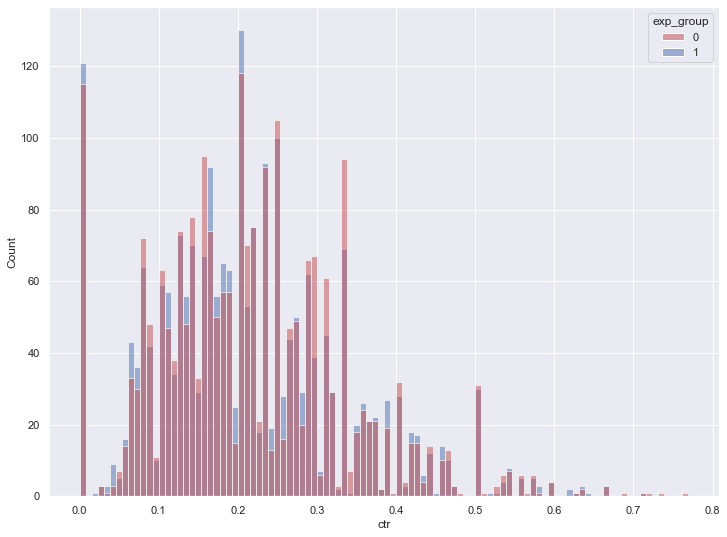

In [11]:
sns.set(rc={'figure.figsize':(12, 9)})

groups = sns.histplot(data = df,
                    x = 'ctr',
                    hue = 'exp_group',
                    palette = ['r', 'b'],
                    alpha = 0.5,
                    kde=False,
                    bins=100)

Визуально группы имеют схожее распределение

### Окончательно проверю разбиение на группы с помощью **Т-критерия Стьюдента**

In [12]:
stats.ttest_ind(df[df['exp_group']==0].ctr,
                df[df['exp_group']==1].ctr,
                equal_var=False)

Ttest_indResult(statistic=1.2312678234437102, pvalue=0.21828551021385284)

**P-value = 0.22, значит отличия в группах не считаются значимыми**

## АB-тесты

1. **exp_group = 1 - Все по-старому. exp_group = 2 - Рекомендации постов, похожих на лайкнутые**
2. **exp_group = 0 – Все по-старому. exp_group = 3 - Рекомендации постов, которые лайкали похожие люди**

### Выгружу данные, для оценки **AB-теста №1** в датафрейм

In [13]:
sql = '''
SELECT exp_group,
    user_id,
    SUM(action = 'like') AS likes,
    SUM(action = 'view') AS views
FROM feed_actions
WHERE time BETWEEN '2021-11-16' AND '2021-11-18'
    AND exp_group IN (1, 2)
GROUP BY exp_group, user_id;
'''

df = query(sql)

df['ctr'] = df['likes']/df['views']

Сравню количество пользователей в группах

In [14]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,2294,2294,2294,2294
2,2242,2242,2242,2242


Визуально рассмотрю распределения CTR по группам

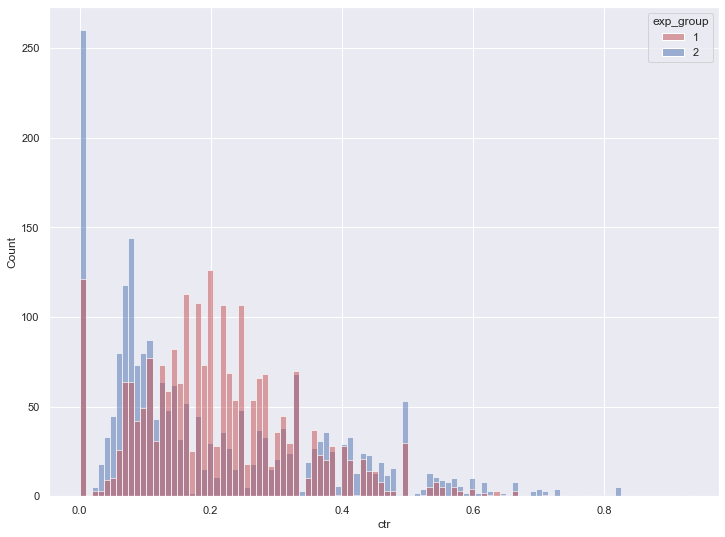

In [15]:
sns.set(rc={'figure.figsize':(12, 9)})

groups = sns.histplot(data = df,
                    x = 'ctr',
                    hue = 'exp_group',
                    palette = ['r', 'b'],
                    alpha = 0.5,
                    kde = False,
                    bins = 100)

Визуально в группах видны отличия, проверю их значимость с помощью **теста Манна-Уитни**

In [16]:
stats.mannwhitneyu(df[df['exp_group'] == 1].ctr,
                df[df['exp_group'] == 2].ctr,
                alternative = 'two-sided')

MannwhitneyuResult(statistic=2885236.5, pvalue=1.1103513761581954e-12)

**P-value < 0.05, значит отличия в группах считаются значимыми**

Проведу **Бутстреп** тест для наглядности

Функция:
- Берет из 1 группы выборку
- Из распределения Пуфасона генерирует сколько раз пользователь попал в выборку (вес)
- Считает глобальный CTR с учетом веса
- Производит те же вычисления для группы 2
- Считает и сохраняет разницу глобальных CTR
- Повторяет процедуру 2000 раз

**Получаю распределение разницы в глобальном CTR**

In [17]:
def bootstrap(likes1, views1, likes2, views2, n_butstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs((2000, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((2000, len(likes2))).astype(np.int64)

    global_ctr1 = (poisson_bootstraps1 * likes1).sum(axis=1)/(poisson_bootstraps1 * views1).sum(axis=1)
    global_ctr2 = (poisson_bootstraps2 * likes2).sum(axis=1)/(poisson_bootstraps2 * views2).sum(axis=1)

    return global_ctr1, global_ctr2

Применю функцию  и визуализирую

<AxesSubplot:ylabel='Count'>

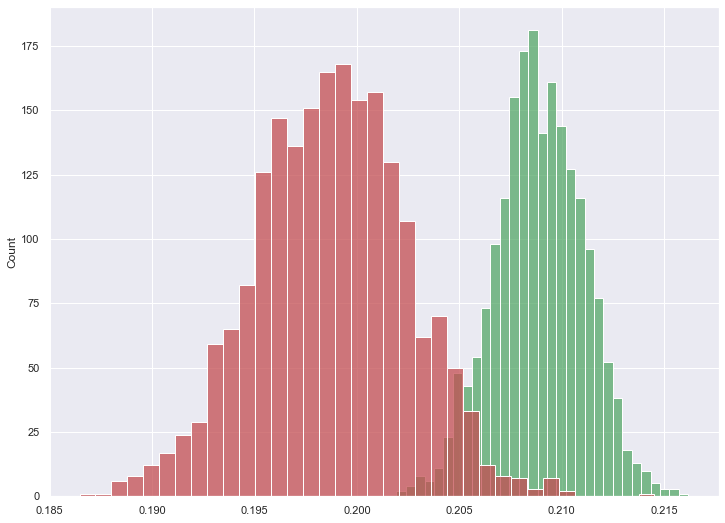

In [18]:
likes1 = df[df['exp_group'] == 1].likes.to_numpy()
views1 = df[df['exp_group'] == 1].views.to_numpy()
likes2 = df[df['exp_group'] == 2].likes.to_numpy()
views2 = df[df['exp_group'] == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color=['g'])
sns.histplot(ctr2, color=['r'])

Рассмотрю распределение разницы между глобальными CTR тестовой и контрольной групп

<AxesSubplot:ylabel='Count'>

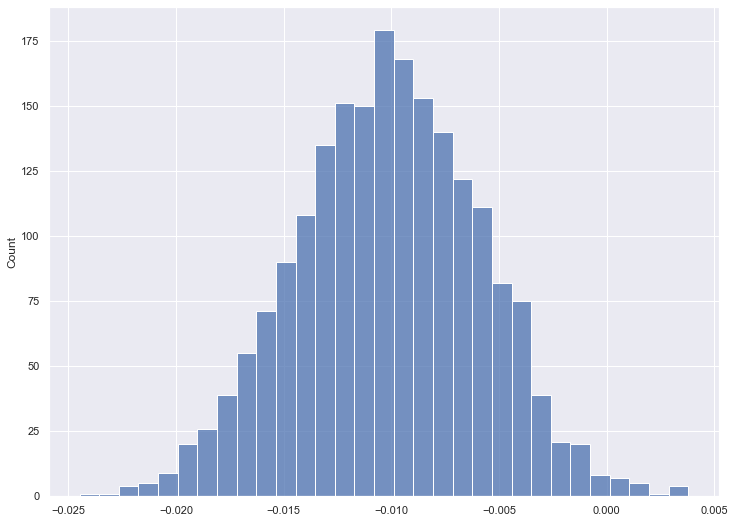

In [19]:
sns.histplot(ctr2 - ctr1, color=['b'])

Распределение разности глобальных CTR строго меньше 0, значит разница между группами отрицательная

**Алгоритм рекомендации постов, похожих на лайкнутые негативно повлиял на CTR**

### Выгружу данные, для оценки **AB-теста №2** в датафрейм

In [20]:
sql = '''
SELECT exp_group,
    user_id,
    SUM(action = 'like') AS likes,
    SUM(action = 'view') AS views
FROM feed_actions
WHERE time BETWEEN '2021-11-16' AND '2021-11-18'
    AND exp_group IN (0, 3)
GROUP BY exp_group, user_id;
'''

df = query(sql)

df['ctr'] = df['likes']/df['views']

Сравню количество пользователей в группах

In [21]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,2319,2319,2319,2319
3,2325,2325,2325,2325


Визуально рассмотрю распределения CTR по группам

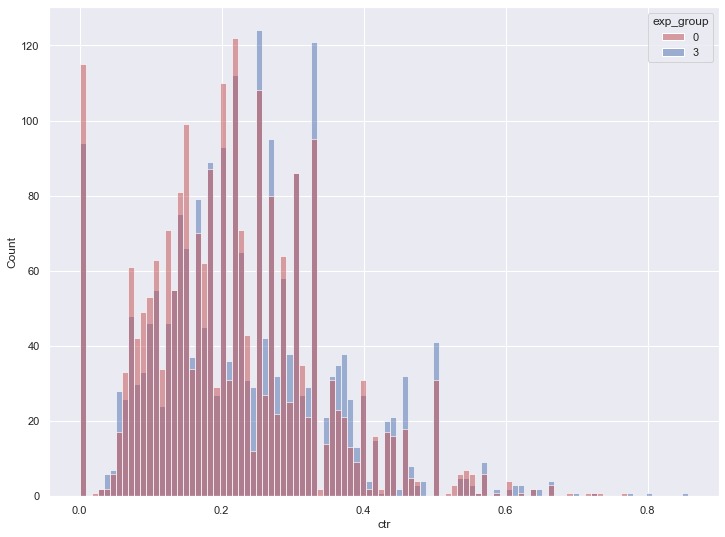

In [22]:
sns.set(rc={'figure.figsize':(12, 9)})

groups = sns.histplot(data = df,
                    x = 'ctr',
                    hue = 'exp_group',
                    palette = ['r', 'b'],
                    alpha = 0.5,
                    kde = False,
                    bins = 100)

Визуально оценить оличия в группах сложно. Проверю значимость отличий с помощью **теста Манна-Уитни**

In [23]:
stats.mannwhitneyu(df[df['exp_group'] == 0].ctr,
                df[df['exp_group'] == 3].ctr,
                alternative = 'two-sided')

MannwhitneyuResult(statistic=2455449.0, pvalue=1.41332532144525e-07)

**P-value < 0.05, значит отличия в группах считаются значимыми**

Применю функцию бутстрепа и визуализирую

<AxesSubplot:ylabel='Count'>

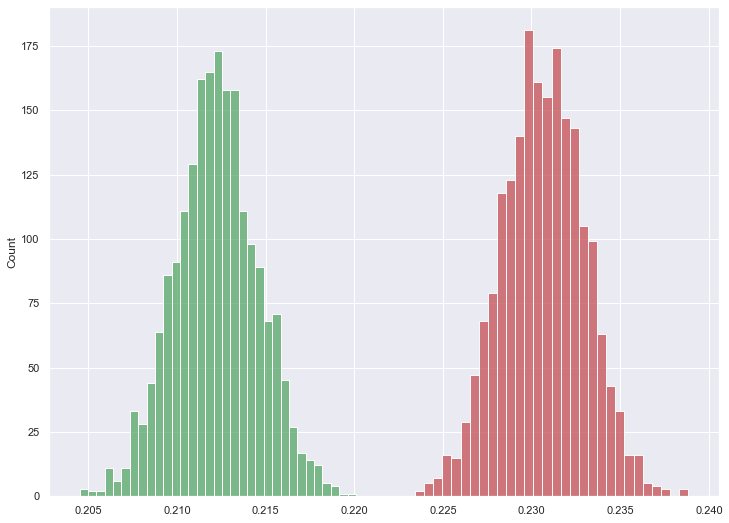

In [24]:
likes1 = df[df['exp_group'] == 0].likes.to_numpy()
views1 = df[df['exp_group'] == 0].views.to_numpy()
likes2 = df[df['exp_group'] == 3].likes.to_numpy()
views2 = df[df['exp_group'] == 3].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color=['g'])
sns.histplot(ctr2, color=['r'])

Рассмотрю распределение разницы между глобальными CTR тестовой и контрольной групп

<AxesSubplot:ylabel='Count'>

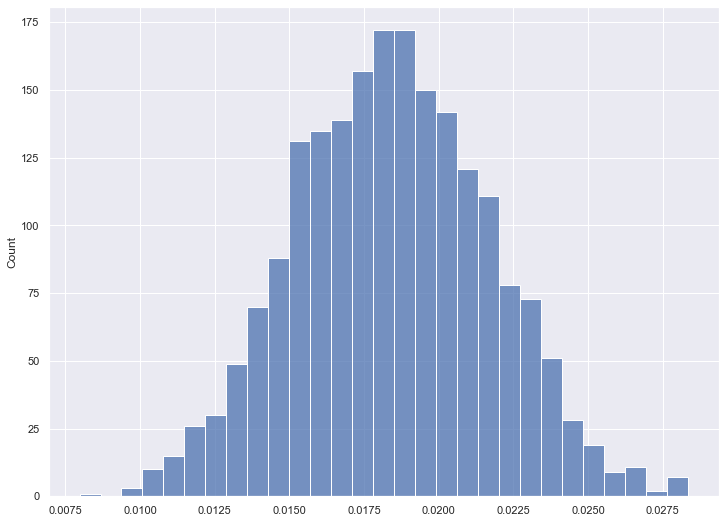

In [25]:
sns.histplot(ctr2 - ctr1, color=['b'])

Распределение разности глобальных CTR строго больше 0, значит разница между группами положительная

**Алгоритм рекомендации постов, которые лайкали похожие люди положительно повлиял на CTR**

## Выводы

- **Алгоритм рекомендации постов, похожих на лайкнутые негативно повлиял на CTR. Алгоритм не стоит выводить в продакшн**
- **Алгоритм рекомендации постов, которые лайкали похожие люди положительно повлиял на CTR. Алгоритм можно выводить в продакшн**